<a href="https://colab.research.google.com/github/ShiningYang0207/ECE661_final_project/blob/main/inpainting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive

/content/drive


In [ ]:
%cd MyDrive/ECE\ 661\ final\ project

/content/drive/.shortcut-targets-by-id/1s7c6Z5jJyUtimJ5tJntlT762pMW9e0xT/ECE 661 final project


In [ ]:
%cd robustness_applications/

/content/drive/.shortcut-targets-by-id/1s7c6Z5jJyUtimJ5tJntlT762pMW9e0xT/ECE 661 final project/robustness_applications


In [ ]:
# install the requirements files
!pip install -r "/content/drive/MyDrive/ECE 661 final project/robustness_applications/requirements.txt"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install cox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import sys
sys.path.insert(0, '/content/drive/MyDrive/Colab Notebooks/ECE 661 final project/robustness_applications/')

In [ ]:
import os
os.environ['NOTEBOOK_MODE'] = '1'
import sys
import torch as ch
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np
import seaborn as sns
from scipy import stats
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt
from robustness import model_utils, datasets
from robustness.tools.vis_tools import show_image_row, show_image_column
from robustness.tools.label_maps import CLASS_DICT
from user_constants import DATA_PATH_DICT
%matplotlib inline

In [ ]:
# Constants
#DATA = 'RestrictedImageNet' # Choices: ['RestrictedImageNet']
DATA = 'ImageNet' # Choices: ['RestrictedImageNet']
BATCH_SIZE = 1
NUM_WORKERS = 8
PATCH_SIZE = 60

DATA_SHAPE = 224 # Image size (fixed for dataset)
REPRESENTATION_SIZE = 2048 # Size of representation vector (fixed for model)

NUM_CLASSES_VIS = 10
GRAIN = 4

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

dataset = ImageFolder(root="dataset/val", transform=transform )
test_loader = ch.utils.data.DataLoader(dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          num_workers=NUM_WORKERS)
data_iterator = enumerate(test_loader)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
dataset

Dataset ImageFolder
    Number of datapoints: 4485
    Root location: dataset/val
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

In [ ]:
device = "cuda" if ch.cuda.is_available() else "cpu"
print("device:", device)

device: cuda


In [ ]:
import torchvision

# Load model
model = torchvision.models.resnet50()
checkpoint = ch.load("models/ImageNet.pt")

In [ ]:
checkpoint.keys()

dict_keys(['model', 'optimizer', 'schedule', 'epoch'])

In [ ]:
import re

modelWeights = {}
for k,v in checkpoint['model'].items():
  if re.match("module\.model[a-z0-9.]*", k):
    newKey = k.split("module.model.")[1]
    modelWeights[newKey] = v

In [ ]:
print(set(modelWeights.keys()).difference(set(model.state_dict().keys())))

set()


In [ ]:
model.load_state_dict(modelWeights)

<All keys matched successfully>

In [ ]:
model = model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Function to get corrupted image
def mask_image(x, width=PATCH_SIZE):
    
    loc = np.random.randint(0, x.shape[-1] - PATCH_SIZE, size=(x.shape[0], 2))
    mask = ch.zeros_like(x)
    for idx in range(x.shape[0]):
        i, j = loc[idx, 0], loc[idx, 1]
        val = ch.mean(ch.mean(x[idx, :], dim=2, keepdim=True), dim=1, keepdim=True)
        # Initialize masked region as mean pixel value over image (per channel)
        x[idx, :, i:i+PATCH_SIZE, j:j+PATCH_SIZE] = val.expand_as(x[idx, :, i:i+PATCH_SIZE, j:j+PATCH_SIZE])
        mask[idx, :, i:i+PATCH_SIZE, j:j+PATCH_SIZE] = 1
    return x, mask

In [ ]:
im_test = []
targ_test = []
while len(targ_test) < 10:
  _, (img_rin, targ_rin) = next(enumerate(test_loader))
  if targ_rin.numpy()[0] not in targ_test:
    im_test.append(img_rin)
    targ_test.append(targ_rin)
    print(targ_test)
img_orig, targ_orig = ch.cat(im_test), ch.cat(targ_test)

[tensor([1])]
[tensor([1]), tensor([4])]
[tensor([1]), tensor([4]), tensor([0])]
[tensor([1]), tensor([4]), tensor([0]), tensor([9])]
[tensor([1]), tensor([4]), tensor([0]), tensor([9]), tensor([2])]
[tensor([1]), tensor([4]), tensor([0]), tensor([9]), tensor([2]), tensor([8])]
[tensor([1]), tensor([4]), tensor([0]), tensor([9]), tensor([2]), tensor([8]), tensor([6])]
[tensor([1]), tensor([4]), tensor([0]), tensor([9]), tensor([2]), tensor([8]), tensor([6]), tensor([7])]
[tensor([1]), tensor([4]), tensor([0]), tensor([9]), tensor([2]), tensor([8]), tensor([6]), tensor([7]), tensor([5])]
[tensor([1]), tensor([4]), tensor([0]), tensor([9]), tensor([2]), tensor([8]), tensor([6]), tensor([7]), tensor([5]), tensor([3])]


In [ ]:
## Remap Labels
label_mapping = {
    -1 : -1,
    0 : 0,
    1 : 217,
    2 : 482,
    3 : 491,
    4 : 497,
    5 : 566,
    6 : 569,
    7 : 571,
    8 : 574,
    9 : 701,
}

targ_orig = targ_orig.numpy()
for i in range(0, len(targ_orig)):
  targ_orig[i] = label_mapping[targ_orig[i]]
targ_orig = ch.tensor(targ_orig)

In [ ]:
targ_orig

tensor([217, 497,   0, 701, 482, 574, 569, 571, 566, 491])

In [ ]:
img_corrupt, mask = mask_image(img_orig.clone())

In [ ]:
from robustness.tools.helpers import InputNormalize
import scipy

# class ModelWithNormalizer(ch.nn.Module):
#     def __init__(self, m, n):
#       super(ModelWithNormalizer, self).__init__()
#       self.model= m
#       self.normalizer = n
    
#     def forward(self, x):
#       return self.model(x)

mean = ch.tensor(scipy.ndimage.mean(img_orig.numpy())).double().cpu()
std = ch.tensor(scipy.ndimage.standard_deviation(img_orig.numpy())).double().cpu()
normalizer = InputNormalize(mean,std)

In [ ]:
def downsample(x, step=GRAIN):
    down = ch.zeros([len(x), 3, DATA_SHAPE//step, DATA_SHAPE//step])

    for i in range(0, DATA_SHAPE, step):
        for j in range(0, DATA_SHAPE, step):
            v = x[:, :, i:i+step, j:j+step].mean(dim=2, keepdim=True).mean(dim=3, keepdim=True)
            ii, jj = i // step, j // step
            down[:, :, ii:ii+1, jj:jj+1] = v
    return down

def upsample(x, step=GRAIN):
    up = ch.zeros([len(x), 3, DATA_SHAPE, DATA_SHAPE])

    for i in range(0, DATA_SHAPE, step):
        for j in range(0, DATA_SHAPE, step):
            ii, jj = i // step, j // step
            up[:, :, i:i+step, j:j+step] = x[:, :, ii:ii+1, jj:jj+1]
    return up

In [ ]:
conditionals = []
for i in tqdm(range(NUM_CLASSES_VIS)):
    imc = img_orig[targ_orig == label_mapping[i]]
    down_flat = downsample(imc).view(len(imc), -1)
    mean = down_flat.mean(dim=0)
    down_flat = down_flat - mean.unsqueeze(dim=0)
    cov = down_flat.t() @ down_flat / len(imc)
    dist = MultivariateNormal(mean, covariance_matrix=cov+1e-4*ch.eye(3 * DATA_SHAPE//GRAIN * DATA_SHAPE//GRAIN))
    conditionals.append(dist)

100%|██████████| 10/10 [01:15<00:00,  7.54s/it]


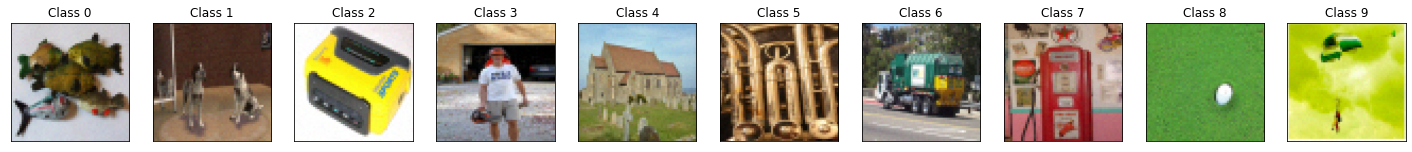

In [ ]:
img_seed = ch.stack([conditionals[i].sample().view(3, DATA_SHAPE//GRAIN, DATA_SHAPE//GRAIN) 
                     for i in range(NUM_CLASSES_VIS)])
#img_seed = ch.clamp(img_seed, min=0, max=1)
img_seed = upsample(ch.clamp(img_seed, min=0, max=1)).to(device)
show_image_row([img_seed.cpu()], tlist=[[f'Class {i}' for i in range(NUM_CLASSES_VIS)]])

In [ ]:
def inpainting_loss(im_targ, inp, mask):
    loss_l2 = ((im_targ - inp) * (1 - mask))**2
    loss_l2 = loss_l2.mean(-1).mean(-1).mean(-1).mean(-1)
    return 10 * loss_l2

def gradient_wrt_data(model, device, data, inp, lbl, mask, normalizer):
    dat = data.clone().detach()
    dat.requires_grad = True
    op = normalizer(dat.cpu())
    out = model(op.float().to(device))
    loss = ch.nn.functional.cross_entropy(out,lbl)
    loss+= inpainting_loss(dat, inp, mask)
    model.zero_grad()
    loss.backward()
    data_grad = dat.grad.data
    return data_grad.data.detach()

In [ ]:
def FGM_L2_attack(model, device, seed, dat, lbl, alpha, iters, mask, normalizer):
    # x_nat is the natural (clean) data batch, we .clone().detach()
    # to copy it and detach it from our computational graph
    x_nat = dat.clone().detach()
    #x_adv = ch.FloatTensor(dat.shape).uniform_(-10, 10).to(device)
    #x_adv = ch.rand(mask.shape).to(device)
    x_adv = x_nat

    for i in range(iters):
      # Compute gradient w.r.t. data
      gradient = gradient_wrt_data(model, device, x_adv, seed, lbl, mask, normalizer)
      # Compute sample-wise L2 norm of gradient (L2 norm for each batch element)
      # HINT: Flatten gradient tensor first, then compute L2 norm
      gradient_flattened = gradient.view(x_nat.size(0), -1)
      l2_of_grad = ch.linalg.norm(gradient_flattened, dim=1, ord=2)
      # Perturb the data using the gradient
      # HINT: Before normalizing the gradient by its L2 norm, use
      # torch.clamp(l2_of_grad, min=1e-12) to prevent division by 0
      l2_of_grad = ch.clamp(l2_of_grad, min=1e-12)
      grad_l2_normalized = gradient / l2_of_grad.view(x_nat.size(0), 1,1,1)
      # Add perturbation the data
      x_adv = x_adv - alpha * grad_l2_normalized
      # Clip the perturbed datapoints to ensure we are in bounds [0,1]
      x_adv = ch.clamp(x_adv, 0.0, 1.0)
      
    # Return the perturbed samples
    return x_adv

In [ ]:
# PGD parameters
kwargs = {
        'constraint':'2',
        'eps': 21.6,
        'step_size': 0.1,
        'iterations': 720, 
        'do_tqdm': True,
        'targeted': True,
        'should_normalize': False
}

In [ ]:
img_inpaint = FGM_L2_attack(model.to(device), device, img_seed.to(device), img_corrupt.to(device), targ_orig.to(device), 
                           kwargs['step_size'], kwargs['iterations'], mask.to(device), normalizer)

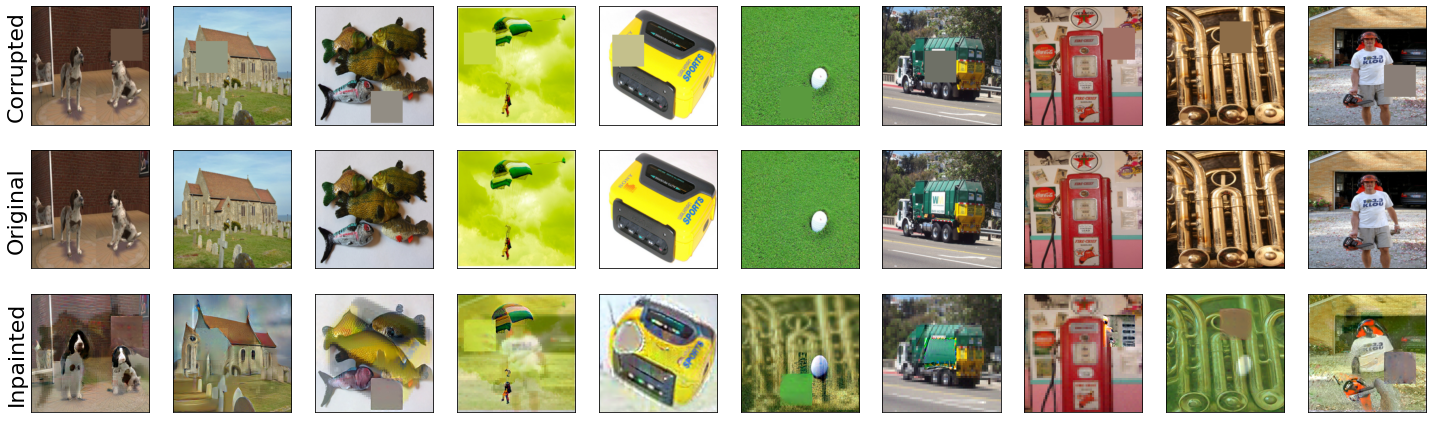

In [ ]:
# Visualize inpainted images
show_image_row([img_corrupt.cpu(), img_orig.cpu(), img_inpaint.detach().cpu()], 
               ["Corrupted", "Original", "Inpainted"],
               fontsize=22)